In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import nolds
import numpy as np

In [2]:
df = pd.read_csv('btc.csv')
df.head()

,date,AdrActCnt,AdrBal1in100KCnt,AdrBal1in100MCnt,AdrBal1in10BCnt,AdrBal1in10KCnt,AdrBal1in10MCnt,AdrBal1in1BCnt,AdrBal1in1KCnt,AdrBal1in1MCnt,...,TxTfrCnt,TxTfrValAdjNtv,TxTfrValAdjUSD,TxTfrValMeanNtv,TxTfrValMeanUSD,TxTfrValMedNtv,TxTfrValMedUSD,VelCur1yr,VtyDayRet180d,VtyDayRet30d
0,2009-01-03,0,0,0,0,0,0,0,0,0,...,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2009-01-04,0,0,0,0,0,0,0,0,0,...,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2009-01-05,0,0,0,0,0,0,0,0,0,...,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2009-01-06,0,0,0,0,0,0,0,0,0,...,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2009-01-07,0,0,0,0,0,0,0,0,0,...,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
df["date"] = df["date"].astype("datetime64")
df = df.set_index("date")

In [4]:
price2021 = df[df.index.year == 2021]['PriceUSD']

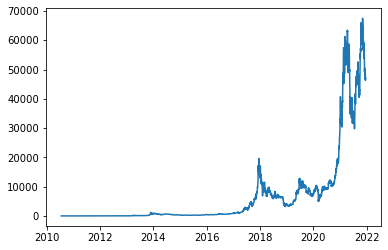

In [5]:
plt.figure()
plt.plot(df['PriceUSD'])

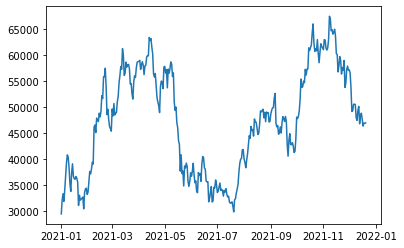

In [6]:
plt.figure()
plt.plot(price2021)

### Sample Entropy

Low values means the series is regular and predicatble.

Let's start by analyzing the entropy for a completely random dataset:

In [7]:
randomDf = np.random.random(size=len(price2021))
nolds.sampen(randomDf)

2.1778816144930886

Its value is 2.2 so pretty high.

Let's find out what's the SampEn value for Bitcoin price in 2021: 

In [8]:
nolds.sampen(price2021)

0.6033316389333855

Pretty low compared to random. It lowers even further when considering BTC close price since 2011:

In [9]:
nolds.sampen(df[df.index.year >= 2011]['PriceUSD'])

0.007457171744891045

<AxesSubplot:xlabel='date'>

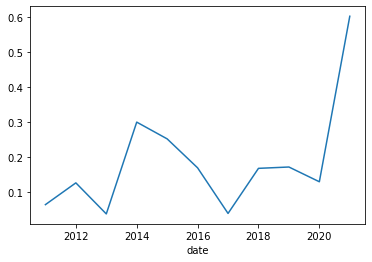

In [10]:
# TODO plot sampen for each year, considering all previous years (since 2011)
df['PriceUSD'].groupby(df.index.year).apply(nolds.sampen).plot()

### Lyapunov exponent

In [11]:
lyape = nolds.lyap_e(price2021)
sum = 0
for i in range(0,len(lyape)):
    if lyape[i] > 0:
        sum += lyape[i]
sum

0.09008588315919042

In [12]:
randU = np.random.choice([85.0, 80.0, 89.0], size=17 * 3)
nolds.lyap_e(randU)

array([-0.10786345, -0.20163997, -0.17660113, -0.25332808], dtype=float32)

In [13]:
nolds.sampen(randU)

0.973860583695633

### Hurst exponent

0.5 is white noise, a greater value means positive dependency on previous data, lower than 0.5 a negative dependency.

<AxesSubplot:xlabel='date'>

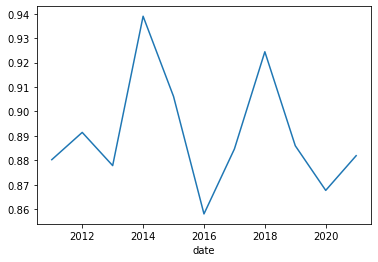

In [14]:
df['PriceUSD'].groupby(df.index.year).apply(nolds.hurst_rs).plot()

At each year we have a positive dependency.

In [15]:
nolds.hurst_rs(df[df.index.year >= 2011]['PriceUSD'])

0.9554426265206133

this holds if we consider all data from 2011.

In [16]:
min(df['PriceUSD'].dropna())

0.05054061835184099

In [17]:
from math import log, sqrt, pi, exp
from scipy.stats import norm
from datetime import datetime, date
import numpy as np
import pandas as pd
from pandas import DataFrame

def d1(S,K,T,r,sigma):
    return(log(S/K)+(r+sigma**2/2.)*T)/(sigma*sqrt(T))
def d2(S,K,T,r,sigma):
    return d1(S,K,T,r,sigma)-sigma*sqrt(T)

In [18]:

def bs_call(S,K,T,r,sigma):
    return S*norm.cdf(d1(S,K,T,r,sigma))-K*exp(-r*T)*norm.cdf(d2(S,K,T,r,sigma))
  
def bs_put(S,K,T,r,sigma):
    return K*exp(-r*T)-S+bs_call(S,K,T,r,sigma)

In [19]:
df['PriceDayBefore'] = df['PriceUSD'].shift(28)

In [20]:
df['returns'] = ((df['PriceUSD'] - df['PriceDayBefore'])/df['PriceDayBefore'])

In [21]:
def sigma(inputDf, upto):
    return df[df.index < upto]['returns'].std()

In [22]:
sigma(df, df.index[len(df)-1])

0.5780636333291445

In [23]:
def month_range(start, end):
    rng = pd.date_range(start=pd.Timestamp(start)-pd.offsets.MonthBegin(),
                        end=end,
                        freq='MS')
    ret = (rng + pd.offsets.Day(pd.Timestamp(start).day-1)).to_series()
    ret.loc[ret.dt.month > rng.month] -= pd.offsets.MonthEnd(1)
    return pd.DatetimeIndex(ret)

In [24]:
expiries = month_range(start=min(df.index), end=max(df.index))+ pd.DateOffset(days=25)
expiries = expiries.repeat(len(df)/len(expiries))
df['expiry'] = df.index
df['expiry'] = df['expiry'].apply(lambda x: x.replace(day=28))
df.loc[df['expiry'] < df.index, 'expiry'] = df.loc[df['expiry'] < df.index, 'expiry'] + pd.DateOffset(months=1)
df['timeToExp'] = (df['expiry'] - df.index).dt.days
df['date'] = df.index
df = df[df['expiry'] != df.index]

In [32]:
df2 = df.dropna()
df2 = df2[df2.index.year == 2021]
optionPrice = df2.apply(axis=1,func=lambda x: bs_call(x['PriceUSD'],x['PriceUSD'],float(x['timeToExp']),x['returns'],sigma(df, x['date'])))
df2 = df2.assign(optionPrice=optionPrice)

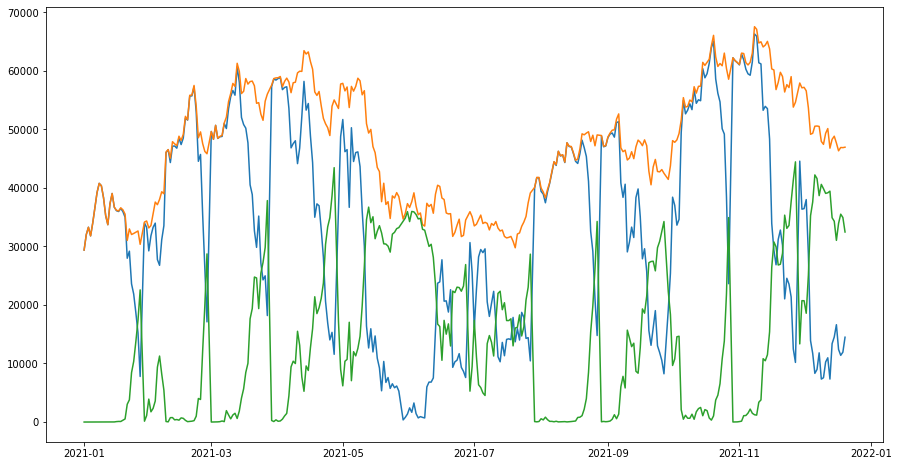

In [33]:
plt.figure(figsize=(15,8))
plt.plot(df2['optionPrice'])
plt.plot(df2['PriceUSD'])
plt.plot(df2['PriceUSD'] - df2['optionPrice'])

<AxesSubplot:xlabel='date'>

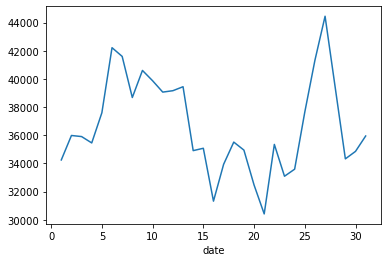

In [34]:
df2['diff'] = df2['PriceUSD'] - df2['optionPrice']
df2.groupby(pd.to_datetime(df2.index).day)['diff'].max().plot()

<AxesSubplot:xlabel='date'>

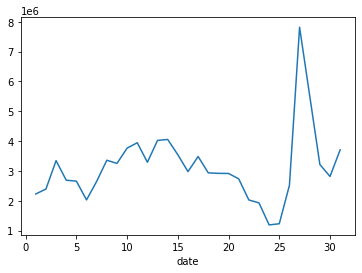

In [28]:
df2.groupby(pd.to_datetime(df2.index).day)['diff'].var().plot()

In [35]:
bias = (df2['diff']*100/max(df2['diff'])).groupby(pd.to_datetime(df2.index).day).mean()*0.01
bias[bias.index == 1].iloc[0]

0.17021082022352235

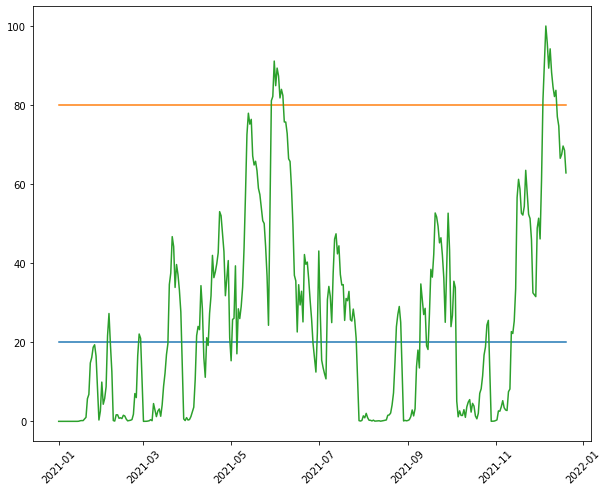

In [37]:
df2['calc'] = df2.apply(axis=1, func=lambda x: x['diff'] * (1-bias[bias.index == pd.to_datetime(x['date']).day].iloc[0]))
df2['calc'] = df2['calc']*100/max(df2['calc'])
df2['limit'] = [20 for i in range(0, len(df2))]
df2['high'] = [80 for i in range(0, len(df2))]
plt.figure(figsize=(10,8))
plt.xticks(rotation=45)
plt.plot(df2['limit'])
plt.plot(df2['high'])
plt.plot(df2['calc'])

In [40]:
df['PriceUSD'].std()

13398.668215233369

In [39]:
df['PriceUSD'].mad()

8282.5324022436

In [72]:
df['meanDiff'] = df.apply(axis=1, func=lambda x: abs(x['PriceUSD'] - df.loc[df.index < x['date'], 'PriceDayBefore'].mean()))

In [67]:
df['stdDiff'] = df.apply(axis=1, func=lambda x: abs(x['PriceUSD'] - df.loc[df.index < x['date'], 'PriceDayBefore'].mean()) - (mdf.loc[df.index < x['date'], 'PriceDayBefore'].std()))

In [68]:
df['madDiff'] = df.apply(axis=1, func=lambda x: abs(x['PriceUSD'] - df.loc[df.index < x['date'], 'PriceDayBefore'].mean()) - (df.loc[df.index < x['date'], 'PriceDayBefore'].mad()))

In [82]:
import scipy as sp
sp.stats.moment(df['PriceUSD'].dropna(), moment=3)/len(df.dropna())**1/3

597321330.6180393

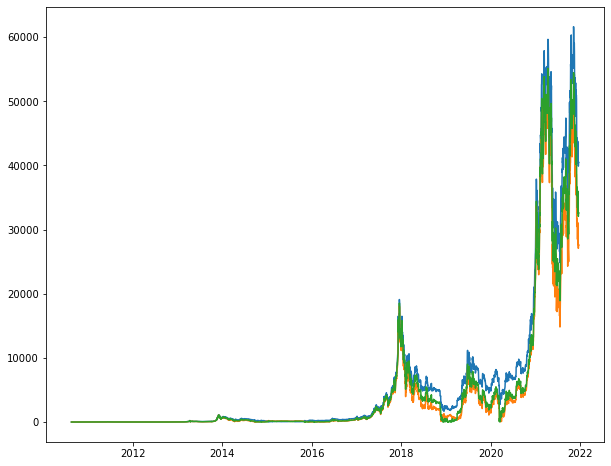

In [83]:
plt.figure(figsize=(10,8))
plt.plot(abs(df['meanDiff']))
plt.plot(abs(df['stdDiff']))
plt.plot(abs(df['madDiff']))

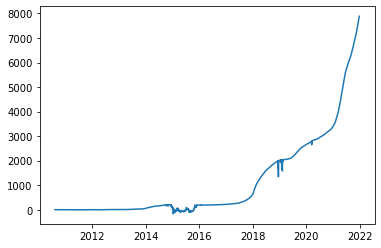

In [74]:
plt.plot(abs(df['meanDiff']) - abs(df['madDiff']))

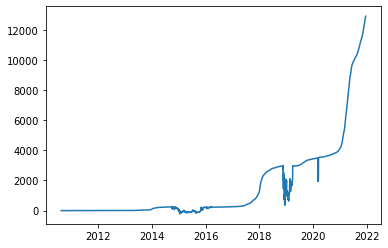

In [75]:
plt.plot(abs(df['meanDiff']) - abs(df['stdDiff']))